<a href="https://colab.research.google.com/github/kristokeith/MachLearn_Ganjil_2023/blob/main/Week%2010/LabWork_Assignment_Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Work 1
*RNN for Sentiment Analysis*

### Step 1 - Setup
Import matplotlib and create a helper function to plot the graph

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Step 2 - Setup Input Pipeline
Download the dataset using TFDS. See loading text tutorial if you want to load the data manually

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially, this returns a dataset (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next, shuffle the data for training and create this pair dataset:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"As an native of Bolton, this film has obvious appeal for me. The location shots are fascinating and show a Bolton very much in transition - there are a number of scenes of apparent dereliction but this serves to show the town being rebuilt - and the idea that the old must make way for the new is right at the heart of this film. A slightly miscast James Mason leads an enjoyable ensemble in a story about a fuss over a herring that spirals into a full-blown generational conflict, then a pleasingly schmaltzy resolution. Though I'm a bit too young to remember it fully, the minutiae of Lancashire life in the 60s is all here: cashing up on a Friday, songs round the piano, the Sunday constitutional, good neighbourliness, the trepidations of courtship, the massive importance of self-respect, and I was pleased to see Naughton's funniest lines from the play left intact. There is no doubt that this film ought to be made available on DVD - it is well crafted and most performances are wel

### Step 3 - Create a Text Encoder
Create this layer and pass the text dataset to the layer's .adapt method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. The first 20 tokens can be seen with the following code. After padding and unknown tokens, they are sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The index tensor is padded with 0s to the longest sequence in the batch (unless if you set output_sequence_length fixed):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,  34,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [ 10,   1, 607, ...,   0,   0,   0]])

With the default settings, the process cannot be fully reversed. There are two main reasons for this:
- The default value for the standardization argument of preprocessing.TextVectorization is "lower_and_strip_punctuation".
- The limited vocabulary size and the lack of character-based fallback result in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"As an native of Bolton, this film has obvious appeal for me. The location shots are fascinating and show a Bolton very much in transition - there are a number of scenes of apparent dereliction but this serves to show the town being rebuilt - and the idea that the old must make way for the new is right at the heart of this film. A slightly miscast James Mason leads an enjoyable ensemble in a story about a fuss over a herring that spirals into a full-blown generational conflict, then a pleasingly schmaltzy resolution. Though I'm a bit too young to remember it fully, the minutiae of Lancashire life in the 60s is all here: cashing up on a Friday, songs round the piano, the Sunday constitutional, good neighbourliness, the trepidations of courtship, the massive importance of self-respect, and I was pleased to see Naughton's funniest lines from the play left intact. There is no doubt that this film ought to be made available on DVD - it is well crafted and most performances are w

### Step 4 - Create a Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00140158]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Step 5 - Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 164ms/step - loss: 0.6396 - accuracy: 0.5718 - val_loss: 0.5057 - val_accuracy: 0.7552
Epoch 2/10
391/391 [==============================] - 27s 70ms/step - loss: 0.5814 - accuracy: 0.6355 - val_loss: 0.4664 - val_accuracy: 0.7797
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3987 - accuracy: 0.8176 - val_loss: 0.3782 - val_accuracy: 0.8214
Epoch 4/10
391/391 [==============================] - 28s 72ms/step - loss: 0.3467 - accuracy: 0.8472 - val_loss: 0.3538 - val_accuracy: 0.8323
Epoch 5/10
391/391 [==============================] - 27s 70ms/step - loss: 0.3292 - accuracy: 0.8557 - val_loss: 0.3421 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 35s 88ms/step - loss: 0.3164 - accuracy: 0.8621 - val_loss: 0.3295 - val_accuracy: 0.8484
Epoch 7/10
391/391 [==============================] - 40s 102ms/step - loss: 0.3109 - accuracy: 0.8648 - val_loss: 0.3332 - val_accurac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 33ms/step - loss: 0.3207 - accuracy: 0.8590
Test Loss: 0.320688933134079
Test Accuracy: 0.8590400218963623


(0.0, 0.6565830573439598)

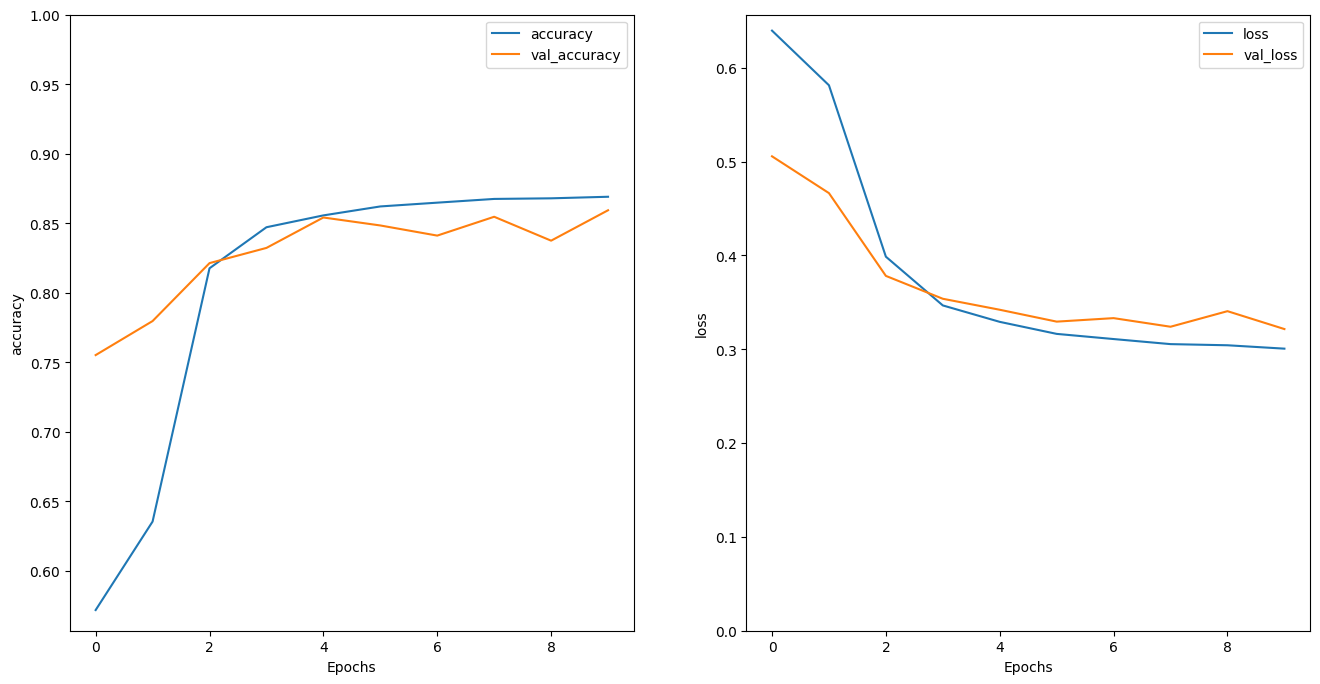

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on a new sentence: If the prediction is >= 0.0, it's positive; otherwise, it's negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


One interesting aspect of using RNNs with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to other RNN layers, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 84s 165ms/step - loss: 0.6276 - accuracy: 0.5864 - val_loss: 0.4481 - val_accuracy: 0.8141
Epoch 2/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3890 - accuracy: 0.8295 - val_loss: 0.3513 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3382 - accuracy: 0.8559 - val_loss: 0.3278 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3219 - accuracy: 0.8645 - val_loss: 0.3279 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3123 - accuracy: 0.8687 - val_loss: 0.3194 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3088 - accuracy: 0.8687 - val_loss: 0.3430 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3036 - accuracy: 0.8716 - val_loss: 0.3217 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 54ms/step - loss: 0.3244 - accuracy: 0.8402
Test Loss: 0.3244428038597107
Test Accuracy: 0.8401600122451782


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.8979416]]


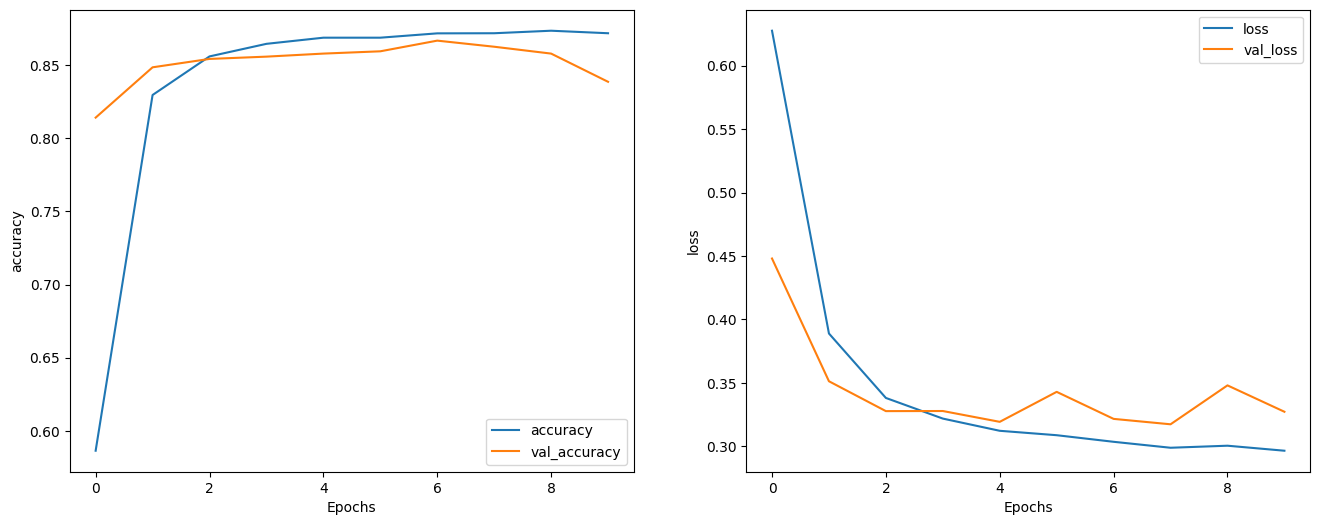

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Lab Work 2
*Text Generator with RNN*

### Step 1 - Setup
**Import TenserFlow**

In [2]:
import tensorflow as tf
import numpy as np
import os
import time

**Download Dataset Shakespeare**

In [3]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**Load Data**

In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Step 2 - Text Processing
**Vectorize Text**

In [7]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the tf.keras.layers.StringLookup layer:

In [8]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

The above command converts tokens into IDs.

In [9]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it's also important to reverse this representation. For this, you can use the tf.keras.layers.StringLookup(..., invert=True) code.

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer converts characters back from the ID vector and returns them as a tf.RaggedTensor:

In [11]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can use tf.strings.reduce_join to recombine characters into a string.

In [12]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [13]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

**Prediction**

**Creating the Training Set and Target**

In [14]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [15]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [16]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [17]:
seq_length = 100

The batch method allows you to easily convert these individual characters into a desired size sequence.

In [18]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It will be easier to see what this does if you recombine the tokens back into a string:

In [19]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()

In [20]:
for seq in sequences.take(5):
    print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training, you need a dataset of pairs (input, label), where input and label are sequences. At each time step, the input is the current character, and the label is the next character. Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each time step:

In [21]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [22]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [23]:
dataset = sequences.map(split_input_target)

In [24]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Creating Batch Training**

In [25]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Step 3 - Create a Model

In [26]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [27]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [28]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### Step 4 - Test the Model
First, check the shape of the output

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the example above, the input sequence length is 100, but the model can be run on input of any length:

In [30]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To get the actual predictions from the model, you need to sample from the output distribution to obtain the actual character index. This distribution is determined by the logits over the character vocabulary. Note: It is important to sample from this distribution because taking the argmax of the distribution can easily get the model stuck in an infinite loop. Try it for the first example in the batch:

In [31]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each time step, the predicted index of the next character:

In [32]:
sampled_indices

array([40, 10, 11, 49, 56, 38, 39, 19, 24, 31,  0, 38, 18, 65, 18, 19, 51,
       11, 12,  9, 64, 62, 61, 36, 33, 57, 54, 24, 43, 52, 32, 41, 14, 24,
       23, 62, 46, 54, 46,  0, 40, 15, 33,  1, 26, 47, 50, 26, 64, 64,  1,
       17, 64, 35, 36, 51, 39, 42,  9, 57, 52, 65, 46, 17, 45, 29, 55, 49,
       27, 65, 46, 17, 31, 38, 21, 48, 55,  9,  3, 39, 53, 48, 64, 35,  3,
       10, 21,  9, 21,  9,  9, 32, 16, 34, 26, 27, 64, 33, 19, 29])

Decode the code below to see the text predicted by this untrained model:

In [33]:
print("Input:\n", text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices))

Input:
 b'mberland.\n\nNORTHUMBERLAND:\nThe commons will not then be satisfied.\n\nKING RICHARD II:\nThey shall be s'

Next Char Predictions:
 b'a3:jqYZFKR[UNK]YEzEFl:;.ywvWTroKdmSbAKJwgog[UNK]aBT\nMhkMyy\nDyVWlZc.rmzgDfPpjNzgDRYHip.!ZniyV!3H.H..SCUMNyTFP'


### Step 5 - Train the Model
**Additional optimizer and loss function**


The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied over the last dimension of predictions. Since your model returns logits, you need to set the from_logits flag.

In [34]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1891437, shape=(), dtype=float32)


A newly initialized model shouldn't be too confident in itself; all log outputs should have similar magnitudes. To confirm this, you can check that the exponential of the average loss is approximately equal to the size of the vocabulary. A significantly higher loss means that the model is too confident about the wrong answers and has poor initialization.

In [36]:
tf.exp(example_batch_mean_loss).numpy()

65.96628

Configure the training procedure using the tf.keras.Model.compile method. Use tf.keras.optimizers.Adam with default arguments and the specified loss function.

In [37]:
model.compile(optimizer='adam', loss=loss)

**Configure Checkpoints**


Use tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training:

In [38]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Run the Training Process**

In [39]:
EPOCHS = 10

In [40]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 13s 54ms/step - loss: 2.6729
Epoch 2/10
172/172 [==============================] - 11s 53ms/step - loss: 1.9528
Epoch 3/10
172/172 [==============================] - 11s 52ms/step - loss: 1.6767
Epoch 4/10
172/172 [==============================] - 11s 54ms/step - loss: 1.5222
Epoch 5/10
172/172 [==============================] - 11s 54ms/step - loss: 1.4285
Epoch 6/10
172/172 [==============================] - 11s 54ms/step - loss: 1.3634
Epoch 7/10
172/172 [==============================] - 11s 55ms/step - loss: 1.3121
Epoch 8/10
172/172 [==============================] - 11s 55ms/step - loss: 1.2668
Epoch 9/10
172/172 [==============================] - 11s 55ms/step - loss: 1.2253
Epoch 10/10
172/172 [==============================] - 11s 55ms/step - loss: 1.1854


### Step 6 - Generate Text

In [41]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

TypeError: ignored

Run it repeatedly to generate some text. Looking at the text generated, you will see that the model knows when to use capital letters, create paragraphs, and mimic Shakespearean writing style. Due to the limited number of training epochs, the model hasn't learned to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

**Export the Generator Model**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

# Lab Assignment
The training procedure in practical 2 is a simple procedure that does not give you much control. This model uses 'teacher-forcing,' which prevents bad predictions from being fed back into the model, so the model never learns to recover from mistakes. So, after you've seen how to run the model manually, you'll implement a custom training loop. This provides a starting point if, for example, you want to implement curriculum learning to help stabilize the open-loop model's output. The most crucial part of the custom training loop is the training step function.
Use tf.GradientTape to track gradient values. You can learn more about this approach by reading the eager execution guide.

The procedure is:
1. Run the model and compute the loss using tf.GradientTape.
2. Calculate the updates and apply them to the model with the optimizer.

In [42]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above code implements the train_step method according to Keras' train_step conventions. This is optional but allows you to modify the training step's behavior while still using Keras Model.compile and Model.fit methods.

In [43]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [44]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [45]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 61ms/step - loss: 2.7274


Or, if you want to have a deeper understanding, you can create your own custom training loop:

In [46]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1851
Epoch 1 Batch 50 Loss 2.0734
Epoch 1 Batch 100 Loss 1.9433
Epoch 1 Batch 150 Loss 1.8659

Epoch 1 Loss: 1.9908
Time taken for 1 epoch 13.47 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8005
Epoch 2 Batch 50 Loss 1.7276
Epoch 2 Batch 100 Loss 1.6644
Epoch 2 Batch 150 Loss 1.6569

Epoch 2 Loss: 1.7142
Time taken for 1 epoch 11.69 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6138
Epoch 3 Batch 50 Loss 1.5444
Epoch 3 Batch 100 Loss 1.5288
Epoch 3 Batch 150 Loss 1.5048

Epoch 3 Loss: 1.5534
Time taken for 1 epoch 12.02 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4388
Epoch 4 Batch 50 Loss 1.4828
Epoch 4 Batch 100 Loss 1.4281
Epoch 4 Batch 150 Loss 1.4200

Epoch 4 Loss: 1.4556
Time taken for 1 epoch 12.05 sec
_____________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?